# Document Similarity and Topic Modeling of arXiv Paper Abstracts


## Project Structure

<ol>
    <li> Introduction </li>
    <li> Data </li>
    <li> Text Preprocessing </li>
    <li> Models </li>
    <li> Evaluation </li>
    <li> Potential Improvements </li>
</ol>


## I. Introduction

In this project, I perform exploratory data analysis on Cornell's arXiv database of STEM papers, and use  natural language processing (NLP) and information retrieval (IR) techniques to answer the following questions:

1. Given that we like document $d_i$, what are the documents most similar in language that might interest us?
2. How can we assign a relevant category to a document without knowing arXiv's classification a priori?

#### Requirements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.bag as db
from dask.distributed import Client
import json

#### Using dask distributed scheduler:

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:58193 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


## II. Data

Before subsetting our data, we can load and perform EDA on the entire dataset using a Dask bag.

In [3]:
papers = db.read_text('arxiv-metadata-oai-snapshot-2020-08-14.json').map(json.loads)

In [4]:
def examine(i):
    ex_i = papers.take(i)[i-1]
    print(json.dumps(ex_i, indent=1))

In [5]:
from ipywidgets import interact

#### Closer Look at Papers in the Dataset:

In [6]:
interact(examine, i=(1, 30));

interactive(children=(IntSlider(value=15, description='i', max=30, min=1), Output()), _dom_classes=('widget-in…

<h4> Some observations for cleaning and analyzing this dataset: </h4>
    
- **Categories**: Some papers are classified as belonging to more than one category. Multiple categories are separated by a single space.
- **Authors Parsed**: A list containing lists of parsed author last name, first name, and typically "". We consider only the (first,last) pairs.



### Category Taxonomy and Top Categories:

In [7]:
from bs4 import BeautifulSoup
import requests

In [8]:
taxonomy_lk = 'https://arxiv.org/category_taxonomy'

In [9]:
text = requests.get(taxonomy_lk).text
soup = BeautifulSoup(text, 'html.parser')
subjects = soup.find_all('h4')[1:]
tax = {}
for subj in subjects:
    abbrev, name = subj.contents
    tax[abbrev.strip()] = name.contents[0].strip('()')
tax = pd.DataFrame(tax.values(), index=tax.keys(), columns=['Subject'])

In [10]:
tax.head()

,Subject
cs.AI,Artificial Intelligence
cs.AR,Hardware Architecture
cs.CC,Computational Complexity
cs.CE,"Computational Engineering, Finance, and Science"
cs.CG,Computational Geometry


### Count

In [11]:
papers.count().compute()

1747307

### Top Categories

In [12]:
ctgry_counts = (papers.map(lambda x: x['categories'].split(' '))
       .flatten()
       .frequencies(sort=True)
       .compute())

In [13]:
cc_df = pd.DataFrame(ctgry_counts, columns=['cat', 'count']).set_index('cat')
subj = tax.join(cc_df).sort_values('count', ascending=False)

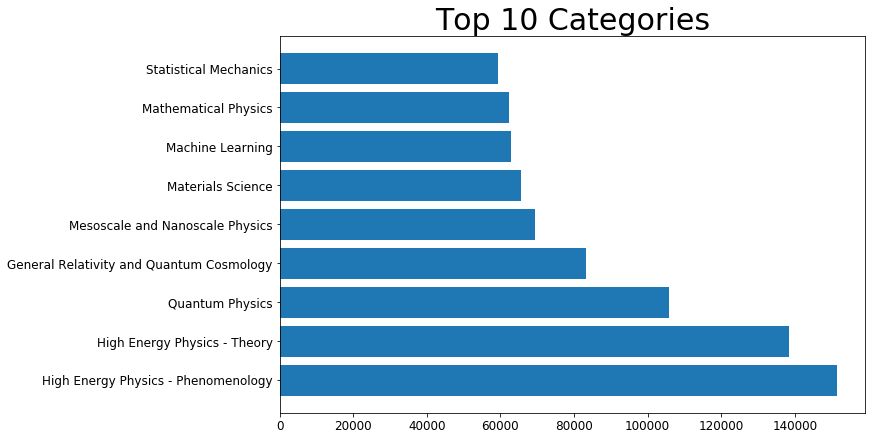

In [14]:
%matplotlib inline
n = 10
fig = plt.figure(figsize=(12,6), constrained_layout=True)
ax = plt.subplot(111)
ax.set_title('Top {} Categories'.format(n), size=30);
ax.barh(subj['Subject'][:n], subj['count'][:n])
ax.tick_params(labelsize=12)

### Top submitters

In [15]:
papers.map(lambda x: x['submitter']).frequencies(sort=True).topk(10, key=1).compute()

[(None, 15191),
 ('EPTCS', 2837),
 ('The CMS Collaboration', 634),
 ('Atlas Publications', 623),
 ('EDA Publishing Association', 391),
 ('Cms Collaboration', 373),
 ('Delfim F. M. Torres', 357),
 ('The ATLAS Collaboration', 319),
 ('Scientific Information Service CERN', 285),
 ('Alice Publications', 269)]

### Top authors (in # of publications)

In [16]:
def author_keys(x):
    return [' '.join(author[:2]).strip() for author in x['authors_parsed']]

In [17]:
(papers.map(lambda x: author_keys(x))
        .flatten()
        .frequencies(sort=True)
        .topk(10, key=1).compute())

[('Zhang Y.', 1616),
 ('Zhang L.', 1096),
 ('Li Y.', 1041),
 ('Wang Y.', 1039),
 ('Wang J.', 1002),
 ('CMS Collaboration', 973),
 ('Gao Y.', 952),
 ('Liu X.', 884),
 ('ATLAS Collaboration', 884),
 ('Yang Z.', 853)]

# III.  Text Preprocessing


We take a subset of papers published after 2018, leaving us with 305,000 papers 

In [18]:
strip = lambda x: {
    'id': x['id'],
    'title': x['title'],
    'category':x['categories'].split(' '),
    'abstract':x['abstract']}
last_version = lambda x: x['versions'][-1]['created']
paper_list = papers.filter(lambda x: int(last_version(x).split(' ')[3]) > 2018).map(strip).compute()
paper_df = pd.DataFrame(paper_list)
paper_df.head()

,id,title,category,abstract
0,0704.1445,Deformed Wigner crystal in a one-dimensional q...,"[cond-mat.str-el, cond-mat.mes-hall]",The spatial Fourier spectrum of the electron...
1,0705.0033,Ergodic Theory: Recurrence,[math.DS],We survey the impact of the Poincar\'e recur...
2,0705.0344,Unifying derived deformation theories,[math.AG],We develop a framework for derived deformati...
3,0705.0825,Einstein's Theory of Gravity in the Presence o...,"[gr-qc, astro-ph, hep-th]",The mysterious `dark energy' needed to expla...
4,0705.2562,Anthropic prediction in a large toy landscape,[hep-th],The successful anthropic prediction of the c...


In [19]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [20]:
len(pd.unique(flatten(paper_df.category.values)))

159

### Tokenization 

Tokenization is the process of chopping string documents into a set of "symbols" that are representative of a document.

For example: 

"Would you like to eat soup?" --> ["Would", "you", "like", "to", "eat", "soup", "?"]

In [21]:
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import spacy
import en_core_web_sm
from spacy import displacy
nlp = en_core_web_sm.load()
stop_words = set(stopwords.words('english'))

#### Custom Tokenization (handling LaTeX)

In [22]:
def tokenize(txt):
    txt = txt.strip()
    txt = txt.replace('\n', ' ')
    txt = re.sub(r'(?=\$)(.*)(?<=\$)', '', txt) 
    txt = re.sub(r'[0-9]', '', txt)     
    txt = re.sub(r'[^a-zA-Z ]+', '', txt)
    tokens = txt.lower().split(' ')
    return tokens

### Lemmatization 

In linguistics, the root or canonical form of a word is referred to a <i> lemma </i>. <i> Inflection </i>  is when a lemma is modified through the addition of prefixes or suffixes, changing features such as the word's tense, number, or plurality. 

For example: 

"We went to several stores this afternoon"  --> "We <b>go</b> to several <b>store</b> this afternoon"



### Removal of Stop Words 



In [23]:
def remove_stop(tokens):
    accepted = []
    for w in tokens:
        if (w not in stop_words) and (len(w) > 1):
            accepted.append(w) 
    return accepted

In [41]:
class Tokenizer:
    def __init__(self, stem=False):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        tokens = [self.wnl.lemmatize(t) for t in tokenize(doc)]
        return remove_stop(tokens)

# IV. Models

In [42]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

### Vectorization

In [43]:
count_v = CountVectorizer(tokenizer=Tokenizer(stem=False),
                                   min_df=0.02,
                                   max_df=0.5)
X_tf = count_v.fit_transform(paper_df['abstract'][:100])

In [45]:
tfidf_v = TfidfVectorizer(tokenizer=Tokenizer(),
                                   min_df=0.02,
                                   max_df=0.5)
X_tfidf = tfidf_v.fit_transform(paper_df['abstract'])

### Latent Semantic Indexing (LSI)

In [46]:
svd = TruncatedSVD(n_components=20, random_state=0)

In [47]:
svd.fit(X_tfidf)

TruncatedSVD(algorithm='randomized', n_components=20, n_iter=5, random_state=0,
             tol=0.0)

In [48]:
vocab = tfidf_v.get_feature_names()
for i, topic in enumerate(svd.components_):
    vocab_topic = zip(vocab, topic)
    sorted_terms = sorted(vocab_topic, key= lambda x:x[1], reverse=True)[:8]
    topic_str = "Topic "+ str(i) + ": "
    for t in sorted_terms:
        topic_str += t[0] + " "
    print(topic_str)

Topic 0: model method system data network result problem show 
Topic 1: network learning image data method neural task training 
Topic 2: problem graph solution equation function prove algorithm space 
Topic 3: quantum state system network algorithm graph problem spin 
Topic 4: graph group network model structure theory edge number 
Topic 5: model quantum state equation system language parameter dynamic 
Topic 6: graph algorithm system problem star time data galaxy 
Topic 7: network equation solution graph field magnetic neural image 
Topic 8: system group network user control paper prove dynamic 
Topic 9: field magnetic data method system graph group spin 
Topic 10: image equation graph quantum method solution data system 
Topic 11: data field network quantum theory equation solution learning 
Topic 12: group problem algorithm star mass galaxy solution quantum 
Topic 13: group data equation state method network energy solution 
Topic 14: method function field system theory quantum gro

### Latent Dirichlet Allocation (LDA)

In [49]:
lda_tf = LatentDirichletAllocation(n_components=20, random_state=0)

In [50]:
lda_tf.fit(X_tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [51]:
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)

In [52]:
lda_tfidf.fit(X_tfidf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

### Visualization of LDA

All credit goes to Carson Sievert and Kenneth E. Shirley for the creation of LDAvis <a href='https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf'>(Sievert and Shirley, 2014)</a>. The tool lets us interactively understand the topics our LDA model generated in the following ways:

https://github.com/cpsievert/LDAvis

1. What is the meaning of each topic?
2. How prevalent is each topic in the overall corpus?
3. How are topics related?

In [53]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [54]:
pyLDAvis.sklearn.prepare(lda_tf, X_tf, count_v)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.178041 -0.032644       1        1  13.780420
15    -0.093021  0.007662       2        1  11.435682
12     0.002964  0.019825       3        1   9.197816
8     -0.026763  0.029115       4        1   7.986311
19     0.140245  0.019357       5        1   7.166851
10     0.021505  0.041308       6        1   6.911847
7     -0.025594 -0.261803       7        1   5.741060
4     -0.005367 -0.039755       8        1   5.481938
6     -0.166783  0.063785       9        1   4.624746
5     -0.022449  0.010988      10        1   4.366631
2     -0.090743 -0.036297      11        1   3.936903
3     -0.022230 -0.132182      12        1   3.543648
14    -0.045722  0.041876      13        1   3.032108
0      0.096683  0.067307      14        1   2.995799
11    -0.071776  0.079394      15        1   2.418781
13    -0.034986  0.039548      16        1   2.142322
17     0.062292  0.041884      17        1   1.986398
1      0.036949  0.049549      18        1   1.828784
18     0.063551 -0.008962      19        1   1.183123
9      0.003203  0.000045      20        1   0.238832, topic_info=          Term       Freq      Total Category  logprob  loglift
446      paper  24.000000  24.000000  Default  30.0000  30.0000
635     theory  33.000000  33.000000  Default  29.0000  29.0000
273   function  23.000000  23.000000  Default  28.0000  28.0000
582      space  26.000000  26.000000  Default  27.0000  27.0000
588     spiral  23.000000  23.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
237   exponent   0.010891   3.286087  Topic20  -6.6796   0.3277
218  essential   0.010891   2.541153  Topic20  -6.6796   0.5848
255    fitness   0.010891   3.853472  Topic20  -6.6796   0.1684
254        fit   0.010891   5.112973  Topic20  -6.6796  -0.1144
253      first   0.010891   8.681548  Topic20  -6.6796  -0.6438

[994 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         5  0.416286      abelian
0        14  0.416286      abelian
1         5  0.302502  accelerated
1         9  0.605004  accelerated
2        11  0.425904    according
...     ...       ...          ...
692       8  0.142567         work
694       5  0.416286           yu
694      14  0.416286           yu
695       2  0.397211         zero
695       9  0.397211         zero

[1843 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 16, 13, 9, 20, 11, 8, 5, 7, 6, 3, 4, 15, 1, 12, 14, 18, 2, 19, 10])

In [55]:
pyLDAvis.sklearn.prepare(lda_tfidf, X_tfidf, tfidf_v)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.048885 -0.142689       1        1  11.657187
6      0.017594 -0.088466       2        1   8.797413
12    -0.040631 -0.127768       3        1   7.791868
18    -0.035949 -0.081940       4        1   6.011841
17     0.080943  0.009363       5        1   5.854850
8     -0.042302 -0.099180       6        1   5.667715
13    -0.044916 -0.076125       7        1   4.451785
9      0.173910 -0.006360       8        1   4.418988
15    -0.056576  0.039860       9        1   4.129396
3      0.169419 -0.006859      10        1   3.985975
11     0.009748  0.018466      11        1   3.978015
5      0.068524  0.082114      12        1   3.941222
1     -0.023025  0.114921      13        1   3.940815
16    -0.089882  0.059952      14        1   3.939573
2     -0.086387  0.038522      15        1   3.814575
7     -0.046601  0.081227      16        1   3.804059
14     0.203340  0.017197      17        1   3.738783
10    -0.057821  0.055295      18        1   3.702786
4     -0.073201  0.080520      19        1   3.245198
19    -0.077302  0.031949      20        1   3.127955, topic_info=            Term         Freq        Total Category  logprob  loglift
440      quantum  6695.000000  6695.000000  Default  30.0000  30.0000
256        group  4543.000000  4543.000000  Default  29.0000  29.0000
255        graph  4459.000000  4459.000000  Default  28.0000  28.0000
516         star  3047.000000  3047.000000  Default  27.0000  27.0000
238       galaxy  2392.000000  2392.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
573        using   264.748120  7109.644975  Topic20  -5.0792   0.1744
26   application   221.259048  4449.834330  Topic20  -5.2586   0.4635
181       energy   226.236815  5319.859977  Topic20  -5.2364   0.3072
550         time   226.424396  5915.647662  Topic20  -5.2355   0.2018
167       effect   206.335441  4512.216112  Topic20  -5.3285   0.3798

[966 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.227987  ability
0         2  0.062005  ability
0         3  0.239434  ability
0         4  0.098254  ability
0         5  0.007631  ability
...     ...       ...      ...
600      16  0.081324     zero
600      17  0.062612     zero
600      18  0.018712     zero
600      19  0.027348     zero
600      20  0.018712     zero

[8524 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 13, 19, 18, 9, 14, 10, 16, 4, 12, 6, 2, 17, 3, 8, 15, 11, 5, 20])